# Estimation of Confidence Intervals for Machine Learning
This notebook presents the usage of python functions to perform empirical
estimation of confidence intervals for machine learning models. This kind of confidence interval estimation is often
called "Bootstrap Confidence Interval" or "Monte Carlo Confidence Interval" estimation.

In [1]:
import numpy as np
from tqdm.auto import tqdm

In [2]:
%%capture

from keras.models import Sequential
from keras.layers import Dense

In [3]:
from sklearn.datasets import load_iris, load_breast_cancer

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
import confidence_interval_estimator_ML as cie

In [5]:
import matplotlib.pyplot as plt

# Basic Usage
The basic usage of the functions is presented by computing different confidence intervals for a random-forest classifier over the iris dataset.

### Loading the Data

In [6]:
# Data loading and presentation

iris_dataset = load_iris()
iris_X, iris_y = iris_dataset['data'], iris_dataset['target']

In [7]:
[(a, b) for (a, b) in zip(iris_X, iris_y)][:5]

[(array([5.1, 3.5, 1.4, 0.2]), 0),
 (array([4.9, 3. , 1.4, 0.2]), 0),
 (array([4.7, 3.2, 1.3, 0.2]), 0),
 (array([4.6, 3.1, 1.5, 0.2]), 0),
 (array([5. , 3.6, 1.4, 0.2]), 0)]

In [8]:
[(a, b) for (a, b) in zip(iris_X, iris_y)][-5:]

[(array([6.7, 3. , 5.2, 2.3]), 2),
 (array([6.3, 2.5, 5. , 1.9]), 2),
 (array([6.5, 3. , 5.2, 2. ]), 2),
 (array([6.2, 3.4, 5.4, 2.3]), 2),
 (array([5.9, 3. , 5.1, 1.8]), 2)]

## Parametric Estimation of Confidence Intervals
In order to perform parametric estimation, we need to fit a classifier to the data and evaluate it

In [9]:
clf = RandomForestClassifier(n_estimators=20, max_depth=3)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)
len(X_train), len(X_test)

(100, 50)

In [11]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
preds = clf.predict(X_test)
preds[:5]

array([1, 0, 2, 1, 1])

In [13]:
accuracy = sum(preds == y_test)/len(y_test)
print(f"Accuracy is {accuracy}%")

Accuracy is 0.98%


### 90%, 95% and 99% Parametric Confidence Intervals

In [14]:
sample_size = len(X_test)
sample_size

50

In [15]:
param_90 = cie.parametric_confidence_interval(confidence_level=.9, mean=accuracy, sample_size=sample_size, verbose=True)
param_90

Computing C.I. assuming the data follow a standard normal distribution
With 0.9% confidence the accuracy of the model is in 0.9773132867658845% +/-0.023.


(0.9773132867658845, 0.02268671323411553)

In [16]:
param_95 = cie.parametric_confidence_interval(confidence_level=.95, mean=accuracy, sample_size=sample_size, verbose=True)

Computing C.I. assuming the data follow a standard normal distribution
With 0.95% confidence the accuracy of the model is in 0.9737167798485266% +/-0.026.


In [17]:
param_99 = cie.parametric_confidence_interval(confidence_level=.99, mean=accuracy, sample_size=sample_size, verbose=True)

Computing C.I. assuming the data follow a standard normal distribution
With 0.99% confidence the accuracy of the model is in 0.9669703310001354% +/-0.033.


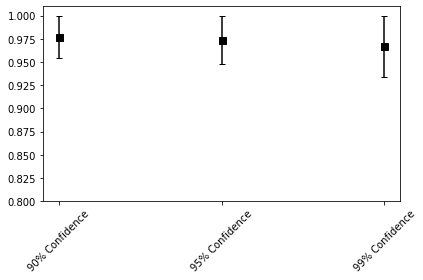

In [18]:
cie.plot_util([param_90, param_95, param_99], ylim=(.8, 1.01))

## Parametric Estimation: t-student Distribution
If the size of the sample for the evaluation of the model has less than 30 datapoints,the function performs the estimation of the confidence intervals under the assumption that the data was drawn from a t-student distribution. Confidence interval estimates with a small sample size tend to be much more unreliable and you should try, if possible, to avoid to use them.

In [19]:
clf = RandomForestClassifier(n_estimators=20, max_depth=3)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.19, random_state=42)
len(X_train), len(X_test)

(121, 29)

In [100]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [101]:
preds = clf.predict(X_test)
accuracy = sum(preds == y_test)/len(y_test)
print(f"Accuracy is {accuracy}%")

Accuracy is 1.0%


In [102]:
sample_size = len(X_test)
sample_size

29

In [103]:
cie.parametric_confidence_interval(confidence_level=.9, mean=accuracy, sample_size=sample_size, verbose=True)

Computing C.I. assuming the data follow a t-distribution (sample_size < 30)
With 0.9% confidence the accuracy of the model is in 1.0% +/-0.0.


(1.0, 0.0)

In [104]:
cie.parametric_confidence_interval(confidence_level=.95, mean=accuracy, sample_size=sample_size, verbose=True)

Computing C.I. assuming the data follow a t-distribution (sample_size < 30)
With 0.95% confidence the accuracy of the model is in 1.0% +/-0.0.


(1.0, 0.0)

## Non-Parametric Estimation of Confidence Intervals
In order to perform non-parametric estimation, we need to fit several classifier to resamplings of the original dataset.

In [26]:
# These parameters will be passed to the constructor of RandomForestClassifier for the creation of each new instance
# Notice that the values are the same of the classifier instantiated for parametric estimation.

rfc_params_dict = {"n_estimators":20, "max_depth":3}

In [27]:
# The accuracy of a random-forest classifier is evaluated on 100 samples of the iris dataset. Each sample is sampled
# with replacement from the original dataset.

accs=cie.get_accuracy_samples(RandomForestClassifier, iris_X, iris_y,
                             model_params_dict=rfc_params_dict,
                             n_iterations=100, sample_ratio=1,
                             train_ratio=0.67, random_seed=None,
                             sample_with_replacement=True, verbose=True)

Evaluating model on 100 samples of (X, y).
Each sample will contain 150 elements from (X, y), out of which 100 elements
will be used to train the model, while the remaining 50 elements to test its accuracy.


In [28]:
[(k, accs[k]) for k in range(5)]

[(0, 0.88), (1, 0.98), (2, 0.96), (3, 0.96), (4, 1.0)]

In [29]:
# Confidence intervals are estimated from the performance of the models in the 100 evaluations.

nonparam_90=cie.nonparametric_confidence_interval(accs, .9)
nonparam_90

From the given data, with 90.0% confidence the accuracy of the model is in 96.0% +/-4.0.


(0.96, 0.039999999999999925)

In [30]:
nonparam_95=cie.nonparametric_confidence_interval(accs, .95)

From the given data, with 95.0% confidence the accuracy of the model is in 95.475% +/-4.525.


In [31]:
nonparam_99=cie.nonparametric_confidence_interval(accs, .99)

From the given data, with 99.0% confidence the accuracy of the model is in 94.0% +/-6.0.


## Comparison of the Estimates
The following plot compares nonparametric and parametric estimates.

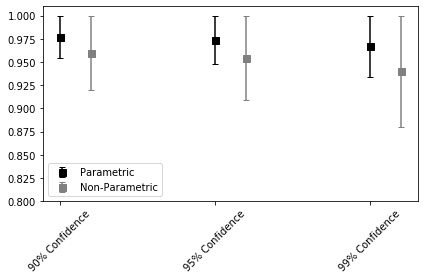

In [32]:
cie.plot_util(intervals_A=[param_90, param_95, param_99],
              intervals_B=[nonparam_90, nonparam_95, nonparam_99],
              label_A="Parametric", label_B="Non-Parametric", ylim=(0.8, 1.01))

# Neural Networks and One-Hot-Encoding
The following example shows how to use the functions with simple neural networks and one hot encoding of labels.

In [109]:
%%capture
iris_y_onehot = OneHotEncoder().fit_transform(iris_y.reshape(-1, 1)).toarray()

In [110]:
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(iris_X, iris_y_onehot, test_size=0.33, random_state=42)
len(X_train), len(X_test)

(100, 50)

In [111]:
y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [112]:
# The following function will return instances of the model

def get_model(hidden_units,  n_output_units, hidden_activation="relu",
              output_activation="softmax", loss="binary_crossentropy",
              optimizer="adam", metric="accuracy"):
    model = Sequential()
    
    for u in hidden_units:
        model.add(Dense(u, activation=hidden_activation))
    model.add(Dense(n_output_units, activation=output_activation))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    return model

## Parametric Estimation
The parametric estimation is shown to give an example of how the model works and to compare it to the nonparametric estimate.

In [123]:
model = get_model(hidden_units=[30, 20, 10],  n_output_units=3)

In [136]:
%%capture

model.fit(X_train, y_train_onehot, epochs = 50, verbose=0, batch_size=10)

In [137]:
model.predict(X_train[:3])

array([[6.4740388e-04, 9.8915219e-01, 1.0200505e-02],
       [6.5870220e-09, 1.1542360e-03, 9.9884570e-01],
       [4.9767917e-04, 8.6955011e-01, 1.2995228e-01]], dtype=float32)

In [138]:
model.evaluate(X_train, y_train_onehot)

100/100 [==============================] - 0s 66us/step


[0.04759719155728817, 0.986666738986969]

In [139]:
(loss, acc) = model.evaluate(X_test, y_test_onehot)
loss, acc

50/50 [==============================] - 0s 80us/step


(0.042104755491018296, 0.986666738986969)

In [140]:
param_90 = cie.parametric_confidence_interval(confidence_level=.9, mean=acc, sample_size=50, verbose=True)
param_90

Computing C.I. assuming the data follow a standard normal distribution
With 0.9% confidence the accuracy of the model is in 0.9829395655094056% +/-0.017.


(0.9829395655094056, 0.017060434490594356)

In [141]:
param_95 = cie.parametric_confidence_interval(confidence_level=.95, mean=acc, sample_size=50, verbose=True)

Computing C.I. assuming the data follow a standard normal distribution
With 0.95% confidence the accuracy of the model is in 0.9799930665039831% +/-0.02.


In [142]:
param_99 = cie.parametric_confidence_interval(confidence_level=.99, mean=acc, sample_size=50, verbose=True)

Computing C.I. assuming the data follow a standard normal distribution
With 0.99% confidence the accuracy of the model is in 0.9744659243967405% +/-0.026.


## Non-Parametric Estimation

In [45]:
dnn_params_dict = {'hidden_units':[30, 20, 10], 'hidden_activation':"relu", 'n_output_units':3,
                   'output_activation':"softmax", 'loss':'binary_crossentropy', 'optimizer':'adam'}

# These parameters will be passed to the network on the calls of the fit method.
dnn_fit_params_dict={'epochs':50, 'batch_size':10, 'verbose':0}

In [46]:
accs=cie.get_accuracy_samples(get_model, iris_X, iris_y_onehot, model_params_dict=dnn_params_dict,
                            fit_params_dict=dnn_fit_params_dict, n_iterations=20, sample_ratio=1,
                            train_ratio=0.67, random_seed=42, sample_with_replacement=True,
                             verbose=True, is_one_hot=True)

Evaluating model on 20 samples of (X, y).
Each sample will contain 150 elements from (X, y), out of which 100 elements
will be used to train the model, while the remaining 50 elements to test its accuracy.


In [47]:
nonparam_90=cie.nonparametric_confidence_interval(accs, .9)
nonparam_90

From the given data, with 90.0% confidence the accuracy of the model is in 95.0% +/-5.0.


(0.95, 0.04999999999999993)

In [48]:
nonparam_95=cie.nonparametric_confidence_interval(accs, .95)

From the given data, with 95.0% confidence the accuracy of the model is in 95.0% +/-5.0.


In [49]:
nonparam_99=cie.nonparametric_confidence_interval(accs, .99)

From the given data, with 99.0% confidence the accuracy of the model is in 95.0% +/-5.0.


## Comparison Plot

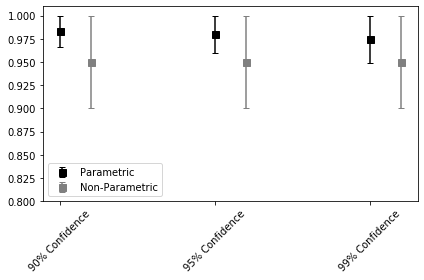

In [143]:
cie.plot_util(intervals_A=[param_90, param_95, param_99],
              intervals_B=[nonparam_90, nonparam_95, nonparam_99],
              label_A="Parametric", label_B="Non-Parametric", ylim=(0.8, 1.01))

# Hyperparameter Tuning and Plots
The following example shows how to compute confidence intervals during the tuning of hyperparameters and how to plot them.  

In [51]:
# Data loading and presentation

cancer_dataset = load_breast_cancer()
cancer_X, cancer_y = cancer_dataset['data'], cancer_dataset['target']
[(a[:5], b) for (a, b) in zip(cancer_X, cancer_y)][:2]

[(array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01]), 0),
 (array([2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02]), 0)]

In [52]:
[(a[:5], b) for (a, b) in zip(cancer_X, cancer_y)][-2:]

[(array([2.060e+01, 2.933e+01, 1.401e+02, 1.265e+03, 1.178e-01]), 0),
 (array([7.760e+00, 2.454e+01, 4.792e+01, 1.810e+02, 5.263e-02]), 1)]

In [53]:
neigbhors= [1, 3, 5, 7, 10, 15, 20, 50, 75, 100, 150, 200]
nn_params_dict = {"n_neighbors":None}

In [54]:
# As an example we will test different hyperparameters for KNN classifiers.

confidence = {90:[], 95:[], 99:[]}
for k in tqdm(neigbhors):
    nn_params_dict["n_neighbors"]=k
    accs=cie.get_accuracy_samples(KNeighborsClassifier, cancer_X, cancer_y,
                             model_params_dict=nn_params_dict,
                             n_iterations=100, sample_ratio=0.7,
                             train_ratio=0.7, random_seed=42,
                             sample_with_replacement=True,
                             verbose=False, progress_bar=False)
    
    confidence[90].append(cie.nonparametric_confidence_interval(accs, .9, verbose=False))
    confidence[95].append(cie.nonparametric_confidence_interval(accs, .95, verbose=False))
    confidence[99].append(cie.nonparametric_confidence_interval(accs, .99, verbose=False))

Accuracy with 90% confidence:


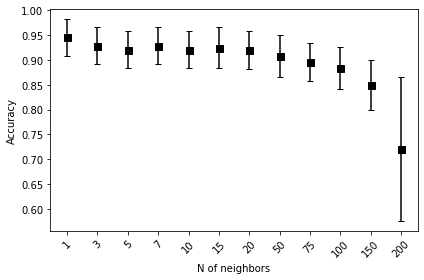

In [55]:
print("Accuracy with 90% confidence:")
cie.plot_util(confidence[90], x_ticks=neigbhors, ylim=None, xlabel="N of neighbors", ylabel="Accuracy")

Accuracy with 95% confidence:


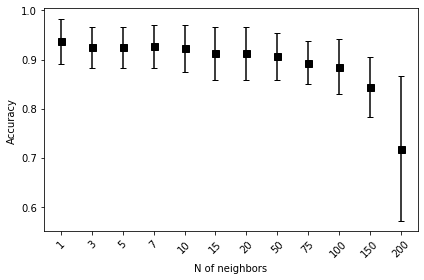

In [56]:
print("Accuracy with 95% confidence:")
cie.plot_util(confidence[95], x_ticks=neigbhors, ylim=None, xlabel="N of neighbors", ylabel="Accuracy")

Accuracy with 99% confidence:


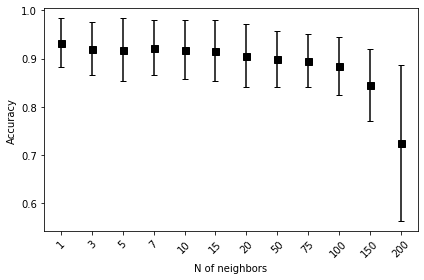

In [57]:
print("Accuracy with 99% confidence:")
cie.plot_util(confidence[99], x_ticks=neigbhors, ylim=None, xlabel="N of neighbors", ylabel="Accuracy")

# Deterministic Resampling
The following example shows the usage of the $\texttt{random_seed}$ parameter.

In [58]:
# Here the random_seed param is set.

accs_run_1=cie.get_accuracy_samples(GaussianNB, cancer_X, cancer_y,
                             n_iterations=100, sample_ratio=0.7,
                             train_ratio=0.8, random_seed=42,
                             sample_with_replacement=True, verbose=True)

Evaluating model on 100 samples of (X, y).
Each sample will contain 398 elements from (X, y), out of which 318 elements
will be used to train the model, while the remaining 80 elements to test its accuracy.


In [59]:
[(k, accs_run_1[k]) for k in range(6)]

[(0, 0.95), (1, 0.9), (2, 0.8875), (3, 0.9625), (4, 0.9625), (5, 0.8625)]

In [60]:
cie.nonparametric_confidence_interval(accs_run_1, .95)

From the given data, with 95.0% confidence the accuracy of the model is in 93.422% +/-5.328.


(0.93421875, 0.05328125000000006)

In [61]:
accs_run_2=cie.get_accuracy_samples(GaussianNB, cancer_X, cancer_y,
                             n_iterations=100, sample_ratio=0.7,
                             train_ratio=0.8, random_seed=42,
                             sample_with_replacement=True, verbose=True)

Evaluating model on 100 samples of (X, y).
Each sample will contain 398 elements from (X, y), out of which 318 elements
will be used to train the model, while the remaining 80 elements to test its accuracy.


In [62]:
# As you can see, the results are identical to the previous run of the function. Be aware that the results
# also depend on the model's characteristic. As an example, if the random seed is set, but the model has 
# some sort of random initialization (i.e. Neural Networks), you may see different results although the
# resampling of the data was identical.

[(k, accs_run_2[k]) for k in range(6)]

[(0, 0.95), (1, 0.9), (2, 0.8875), (3, 0.9625), (4, 0.9625), (5, 0.8625)]

In [63]:
cie.nonparametric_confidence_interval(accs_run_2, .95)

From the given data, with 95.0% confidence the accuracy of the model is in 93.422% +/-5.328.


(0.93421875, 0.05328125000000006)

In [64]:
# Here the random_seed param is set to None

accs_run_3=cie.get_accuracy_samples(GaussianNB, cancer_X, cancer_y,
                             n_iterations=100, sample_ratio=0.7,
                             train_ratio=0.8, random_seed=None,
                             sample_with_replacement=True, verbose=True)

Evaluating model on 100 samples of (X, y).
Each sample will contain 398 elements from (X, y), out of which 318 elements
will be used to train the model, while the remaining 80 elements to test its accuracy.


In [65]:
[(k, accs_run_3[k]) for k in range(6)]

[(0, 0.9125), (1, 0.95), (2, 0.95), (3, 0.9), (4, 0.975), (5, 0.95)]

In [66]:
cie.nonparametric_confidence_interval(accs_run_3, .95)

From the given data, with 95.0% confidence the accuracy of the model is in 93.125% +/-5.625.


(0.93125, 0.05625000000000002)

In [67]:
accs_run_4=cie.get_accuracy_samples(GaussianNB, cancer_X, cancer_y, 
                             n_iterations=100, sample_ratio=0.7,
                             train_ratio=0.8, random_seed=None,
                             sample_with_replacement=True, verbose=True)

Evaluating model on 100 samples of (X, y).
Each sample will contain 398 elements from (X, y), out of which 318 elements
will be used to train the model, while the remaining 80 elements to test its accuracy.


In [68]:
[(k, accs_run_4[k]) for k in range(6)]

[(0, 0.975), (1, 0.975), (2, 0.9625), (3, 0.925), (4, 0.95), (5, 1.0)]

In [69]:
cie.nonparametric_confidence_interval(accs_run_4, .95)

From the given data, with 95.0% confidence the accuracy of the model is in 93.75% +/-5.656.


(0.9374999999999999, 0.05656249999999996)